In [1]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import hvplot.pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime

from sklearn.metrics import r2_score
import statsmodels.api as sm

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define constants
SEQUENCE_LENGTH = 10
FUTURE_STEPS = 180

# Data Preparation

In [2]:
# Read the CSV file
df = pd.read_csv('D:/Desktop/FPT Historical Data.csv')

In [3]:
# some format data
df.set_index('Date',drop=True,inplace=True)

In [4]:
df.head(20)

,Price
Date,
12/14/2006,17021.1
12/15/2006,17872.1
12/18/2006,18763.7
12/19/2006,19695.8
12/20/2006,20668.4
12/21/2006,19655.3
12/22/2006,18682.6
12/25/2006,17750.5
12/26/2006,18601.6


In [5]:
# Plot using hvplot
plot = df.hvplot.line(title='Time Series Plot', xlabel='Date', ylabel='Price')

# Show the plot
plot

:Curve   [Date]   (Price)

In [6]:
# Extract the 'Close' prices for modeling
prices = df['Price'].values.reshape(-1, 1)

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [8]:
prices_scaled

array([[0.14617319],
       [0.15503653],
       [0.16432273],
       ...,
       [0.92188598],
       [0.92084446],
       [0.93334271]])

# Sequence Creation

In [9]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

In [10]:
# Set the sequence length (number of time steps to look back)
sequence_length = 10

In [11]:
# Create sequences for training
X, y = create_sequences(prices_scaled, sequence_length)

# Train-Dev-Test Split

In [12]:
# function to plit the data into train, dev, and test sets
def train_dev_test_split(data, seq_length, train_ratio=0.75, dev_ratio=0.15):
    total_size = len(data)
    train_size = int(total_size * train_ratio)
    dev_size = int(total_size * dev_ratio)

    X, y = create_sequences(data, seq_length)

    X_train, y_train = X[:train_size], y[:train_size]
    X_dev, y_dev = X[train_size:train_size + dev_size], y[train_size:train_size + dev_size]
    X_test, y_test = X[train_size + dev_size:], y[train_size + dev_size:]

    return (X_train, y_train), (X_dev, y_dev), (X_test, y_test)

In [13]:
# X_train, y_train = X[:train_size], y[:train_size]
# X_dev, y_dev = X[train_size:train_size + dev_size], y[train_size:train_size + dev_size]
# X_test, y_test = X[train_size + dev_size:], y[train_size + dev_size:]

(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = train_dev_test_split(prices_scaled, SEQUENCE_LENGTH)


# Reshape Data for LSTM

In [14]:
# Reshape input data to be 3D for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], X_dev.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [15]:
X_train

array([[[0.14617319],
        [0.15503653],
        [0.16432273],
        ...,
        [0.15377004],
        [0.16263442],
        [0.17149776]],

       [[0.15503653],
        [0.16432273],
        [0.17403074],
        ...,
        [0.16263442],
        [0.17149776],
        [0.17149776]],

       [[0.16432273],
        [0.17403074],
        [0.18416056],
        ...,
        [0.17149776],
        [0.17149776],
        [0.16305624]],

       ...,

       [[0.29629063],
        [0.29195061],
        [0.29567092],
        ...,
        [0.29691137],
        [0.30249184],
        [0.30373229]],

       [[0.29195061],
        [0.29567092],
        [0.29815182],
        ...,
        [0.30249184],
        [0.30373229],
        [0.30435199]],

       [[0.29567092],
        [0.29815182],
        [0.30187213],
        ...,
        [0.30373229],
        [0.30435199],
        [0.31923323]]])

# LSTM Model Definition and Training

In [16]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_dev, y_dev))

Epoch 1/100

99/99 [==============================] - 6s 18ms/step - loss: 0.0010 - val_loss: 6.0189e-04
Epoch 2/100
99/99 [==============================] - 1s 9ms/step - loss: 5.2292e-05 - val_loss: 4.0779e-04
Epoch 3/100
99/99 [==============================] - 1s 9ms/step - loss: 5.5809e-05 - val_loss: 5.4262e-04
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 4.8329e-05 - val_loss: 3.6331e-04
Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 5.1650e-05 - val_loss: 5.6208e-04
Epoch 6/100
99/99 [==============================] - 1s 9ms/step - loss: 5.2167e-05 - val_loss: 4.5506e-04
Epoch 7/100
99/99 [==============================] - 1s 9ms/step - loss: 4.7591e-05 - val_loss: 6.2145e-04
Epoch 8/100
99/99 [==============================] - 1s 9ms/step - loss: 5.0005e-05 - val_loss: 6.1820e-04
Epoch 9/100
99/99 [==============================] - 1s 9ms/step - loss: 5.3800e-05 - val_loss: 4.8231e-04
Epoch 10/100
99/99 [===================

99/99 [==============================] - 1s 11ms/step - loss: 1.1213e-05 - val_loss: 1.0572e-04
Epoch 75/100
99/99 [==============================] - 1s 11ms/step - loss: 1.0518e-05 - val_loss: 3.2482e-04
Epoch 76/100
99/99 [==============================] - 1s 11ms/step - loss: 9.9267e-06 - val_loss: 1.0591e-04
Epoch 77/100
99/99 [==============================] - 1s 11ms/step - loss: 1.1200e-05 - val_loss: 9.7285e-05
Epoch 78/100
99/99 [==============================] - 1s 12ms/step - loss: 1.1241e-05 - val_loss: 1.2983e-04
Epoch 79/100
99/99 [==============================] - 1s 10ms/step - loss: 1.1641e-05 - val_loss: 2.0910e-04
Epoch 80/100
99/99 [==============================] - 1s 12ms/step - loss: 9.8998e-06 - val_loss: 1.0814e-04
Epoch 81/100
99/99 [==============================] - 1s 11ms/step - loss: 1.0621e-05 - val_loss: 1.1567e-04
Epoch 82/100
99/99 [==============================] - 1s 11ms/step - loss: 9.6715e-06 - val_loss: 1.0763e-04
Epoch 83/100
99/99 [============

# Model Evaluation and Visualization

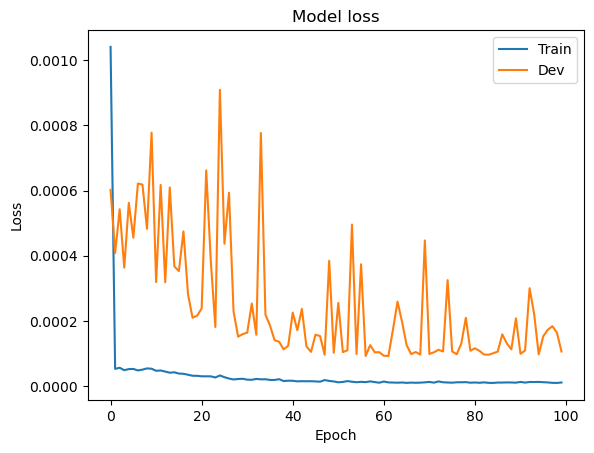

In [18]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

In [19]:
# Make predictions on the test set
predictions = model.predict(X_test)

13/13 [==============================] - 1s 4ms/step


In [20]:
# Inverse transform the predictions and actual values to the original scale
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [21]:
# Compare predictions with actual values
comparison_df = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': predictions_inv.flatten()})
print(comparison_df)

      Actual     Predicted
0    78833.0  78229.328125
1    80810.0  78054.054688
2    86412.0  80674.695312
3    87318.0  86834.726562
4    88142.0  85498.054688
..       ...           ...
407  92600.0  86426.726562
408  92500.0  92745.398438
409  91500.0  89931.062500
410  91400.0  89872.906250
411  92600.0  89879.257812

[412 rows x 2 columns]


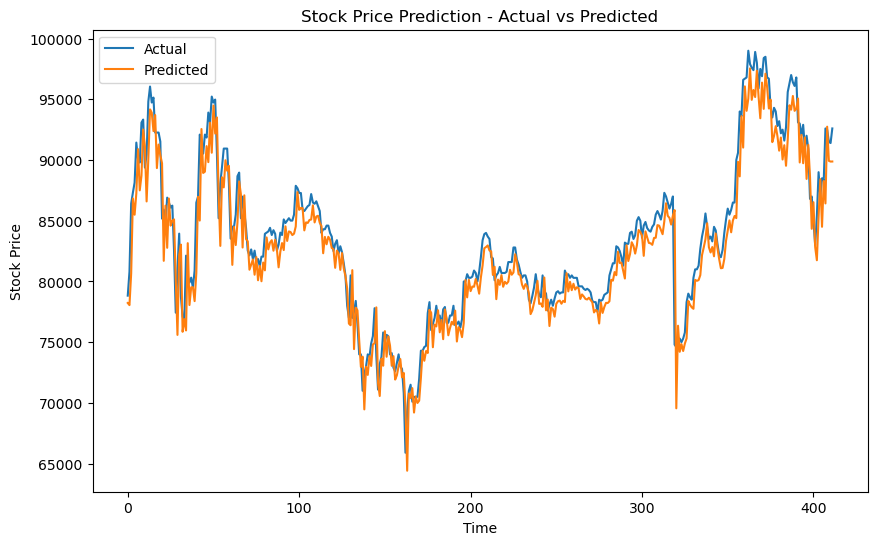

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(comparison_df['Actual'], label='Actual')
plt.plot(comparison_df['Predicted'], label='Predicted')
plt.title('Stock Price Prediction - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [23]:
# Convert the DataFrame to a format compatible with hvplot
comparison_df_hv = comparison_df.reset_index()

# Plot using hvplot
plot = comparison_df_hv.hvplot.line(x='index', y=['Actual', 'Predicted'], xlabel='Time', ylabel='Stock Price', title='Stock Price Prediction - Actual vs Predicted', height=400, width=600, legend='top_left')
plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [24]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, predictions_inv)
mae = mean_absolute_error(y_test_inv, predictions_inv)
r2 = r2_score(y_test_inv, predictions_inv)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R-squared (R2): {r2:.2f}')

Mean Squared Error (MSE): 4149204.31
Mean Absolute Error (MAE): 1529.53
R-squared (R2): 0.90


# Predicting Future Values

In [25]:
# Number of time steps to predict into the future
future_steps = 10

# Generate sequences for prediction
X_future = X_test[-1].reshape(1, sequence_length, 1)  # Use the last sequence from the test set


In [26]:
# Predict future values
future_predictions = []
for _ in range(future_steps):
    future_prediction = model.predict(X_future)
    future_predictions.append(future_prediction)
    X_future = np.append(X_future[:, 1:, :], future_prediction.reshape(1, 1, 1), axis=1)

1/1 [==============================] - 0s 42ms/step


In [27]:
# Inverse transform the future predictions to the original scale
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [28]:
# Create an index for the future predictions
future_index = pd.date_range(start=df.index[-1], periods=future_steps + 1, freq='D')[1:]

# Convert the DataFrames to a format compatible with hvplot
comparison_df_hv = comparison_df.reset_index()
historical_prices_hv = pd.DataFrame({'Date': df.index, 'Price': scaler.inverse_transform(prices_scaled).flatten()})
future_predictions_hv = pd.DataFrame({'Date': future_index, 'Future Predictions': future_predictions_inv.flatten()})

In [29]:
# some format data
historical_prices_hv.set_index('Date',drop=True,inplace=True)
future_predictions_hv.set_index('Date',drop=True,inplace=True)

In [30]:
historical_prices_hv

,Price
Date,
12/14/2006,17021.1
12/15/2006,17872.1
12/18/2006,18763.7
12/19/2006,19695.8
12/20/2006,20668.4
...,...
11/8/2023,92600.0
11/9/2023,92500.0
11/10/2023,91500.0


In [31]:
future_predictions_hv

,Future Predictions
Date,
2023-11-15,89879.265625
2023-11-16,87839.234375
2023-11-17,86060.757812
2023-11-18,84491.750000
2023-11-19,83059.039062
2023-11-20,81744.171875
2023-11-21,80539.750000
2023-11-22,79432.328125
2023-11-23,78409.546875


<Axes: xlabel='Date'>

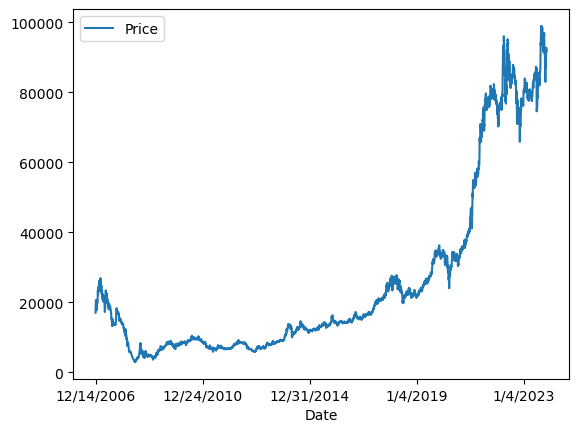

In [32]:
historical_prices_hv.plot()

<Axes: xlabel='Date'>

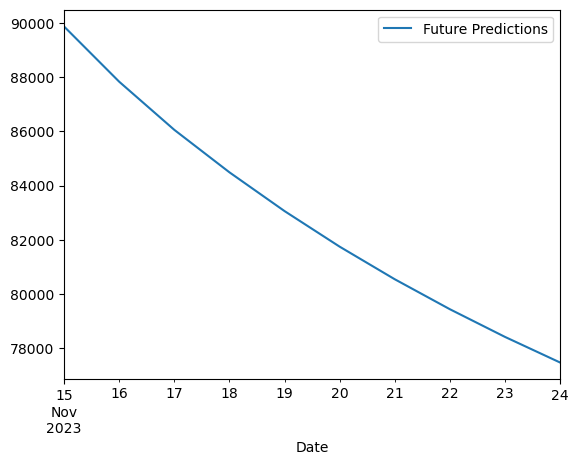

In [33]:
future_predictions_hv.plot()

In [34]:
# Convert the index to datetime format if it's not already
historical_prices_hv.index = pd.to_datetime(historical_prices_hv.index)
future_predictions_hv.index = pd.to_datetime(future_predictions_hv.index)

# Plot using hvplot
historical_plot = historical_prices_hv.hvplot(title='Historical Prices', xlabel='Date', ylabel='Price', line_color='blue')
future_plot = future_predictions_hv.hvplot(title='Future Predictions', xlabel='Date', ylabel='Predicted Price', line_color='orange')

# Overlay the plots
combined_plot = historical_plot * future_plot

# Show the plot
combined_plot

:Overlay
   .Curve.I  :Curve   [Date]   (Price)
   .Curve.II :Curve   [Date]   (Future Predictions)

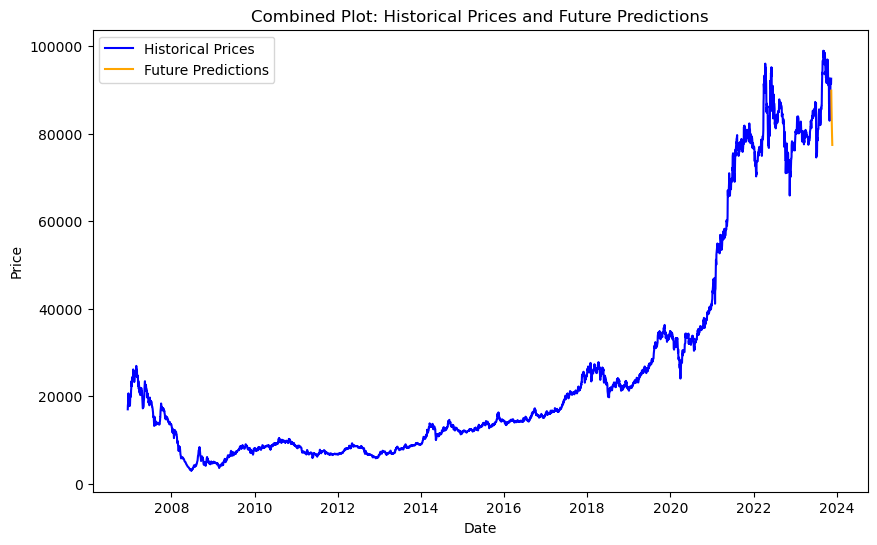

In [35]:
# Plot using Matplotlib's plt
plt.figure(figsize=(10, 6))

# Historical Prices
plt.plot(historical_prices_hv.index, historical_prices_hv, label='Historical Prices', color='blue')

# Future Predictions
plt.plot(future_predictions_hv.index, future_predictions_hv, label='Future Predictions', color='orange')

# Set titles and labels
plt.title('Combined Plot: Historical Prices and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price')

# Show legend
plt.legend()

# Show the plot
plt.show()